# Семинар, часть 1

# Метод Ньютона

## Реализация метода Ньютона

- Классический метод Ньютона: $\alpha_k \equiv 1$
- Демпфированный метод Ньютона: $\alpha_k$ выбирается на каждой итерации по заданному правилу

```python
def NewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    while True:
        
        h = ComputeNewtonStep(x, f, **kwargs)
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
    return x

```

### Пример

Применим метод Ньютона для поиска корня следующей функции

$$
\varphi(t) = \dfrac{t}{\sqrt{1+t^2}}
$$

и определим область сходимости.

## Аффинная инвариантность

Рассмотрим функцию $f(x)$ и невырожденное преобразование с матрицей $A$. 

Выясним, как изменится шаг метода Ньютона после преобразования $A$.

Пусть $x = Ay$ и $g(y) = f(Ay)$. Тогда

$$
g(y + u) \approx g(y) + \langle g'(y), u \rangle + \frac{1}{2} u^{\top} g''(y) u \to \min_{u}
$$

и

$$
u^* = -(g''(y))^{-1} g'(y) \qquad y_{k+1} = y_k - (g''(y_k))^{-1} g'(y_k)
$$

или

\begin{align*}
y_{k+1} & = y_k - (A^{\top}f''(Ay_k)A)^{-1} A^{\top}f'(Ay_k)\\
& = y_k - A^{-1}(f''(Ay_k))^{-1}f'(Ay_k)
\end{align*}

Таким образом,

$$
Ay_{k+1} = Ay_k - (f''(Ay_k))^{-1}f'(Ay_k) \quad x_{k+1} = x_k - (f''(x_k))^{-1}f'(x_k)
$$

Следовательно, направление метода Ньютона преобразуется при 

линейном преобразовани так же, как и координаты!

### Метод Ньютона с модификацией гессиана

- Как быть с возможной неположительной определённостью гессиана на некоторой итерации?
- Если $f''(x)$ неположительно определён, использовать положительно определённую матрицу $f''(x) + \Delta E$
- Матрицу $\Delta E$ можно выбирать различными способами исходя из следующей задачи
$$
\Delta E = \arg\min \|\Delta E\|, \quad \text{s.t. } f''(x) + \Delta E \succ 0
$$
    - $\|\cdot\|_2$: $\Delta E = \tau I$, где $\tau = \max(0, \delta - \lambda_{\min}(f''(x)))$, где $\delta > 0$ - заданная оценка снизу минимального собственного значения матрицы $f''(x) + \Delta E$
    - Чему равно $\Delta E$ при использовании $\|\cdot\|_F$?
    
- Поскольку оценку $\lambda(f''(x))$ обычно сложно вычислять на каждой итерации, возможно модифицировать процедуру вычисления разложения Холецкого матрицы $f''(x)$ так чтобы в итоге получилось разложение Холецкого для матрицы $f''(x) + \Delta E$

## Вычислительная сложность и эксперименты

Узкие места метода Ньютона:

- формирование и хранение гессиана
- решение систем линейных уравнений

$$
f''(x_k)h = -f'(x_k)
$$

### Сравнение с градиентным спуском

Вспомним задачу нахождения аналитического центра системы неравенств $Ax \leq 1$ при условии $|x_i| \leq 1$

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

$$
f'(x) - ? \quad f''(x) - ?
$$ 

In [11]:
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

n = 2000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10

#### Точное решение с помощью CVXPy

In [12]:
import cvxpy as cvx
x = cvx.Variable((n, 1))

obj = cvx.Minimize(cvx.sum(-cvx.log(1 - A.T * x)) - 
                   cvx.sum(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(solver="SCS", verbose=True, max_iters=1000)
print("Optimal value =", prob.value)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 410200, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
Variables n = 6200, constraints m = 12600
Cones:	soc vars: 6000, soc blks: 2000
	exp vars: 6600, dual exp vars: 0
Setup time: 1.61e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf      -inf       inf  4.68e-02 
   100| 2.26e+01  6.07e+00  8.26e-03 -2.03e+04 -2.00e+04  4.70e-13  1.81e+00 
   200| 3.15e+00  9.27e-01  3.27e-03 -2.58e+03 -2.56e+03  4.52e-13  3.87e+00 
   300| 

#### Вспомогательные функции

In [13]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

#### Реализация метода Ньютона

In [14]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

#### Сравнение с градиентным спуском

In [15]:
newton = methods.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_newton = newton.solve(x0, tol=1e-6, max_iter=50, disp=True)

gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_gd = gd.solve(x0, tol=1e-6, max_iter=50, disp=True)

Required tolerance achieved!
Convergence in 15 iterations
Function value = -1439.9893829202101
Norm of gradient = 6.333352269029533e-13


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Maximum iteration exceeds!
Convergence in 50 iterations
Function value = -1439.9893829202101
Norm of gradient = 2.0000176683958207e-06


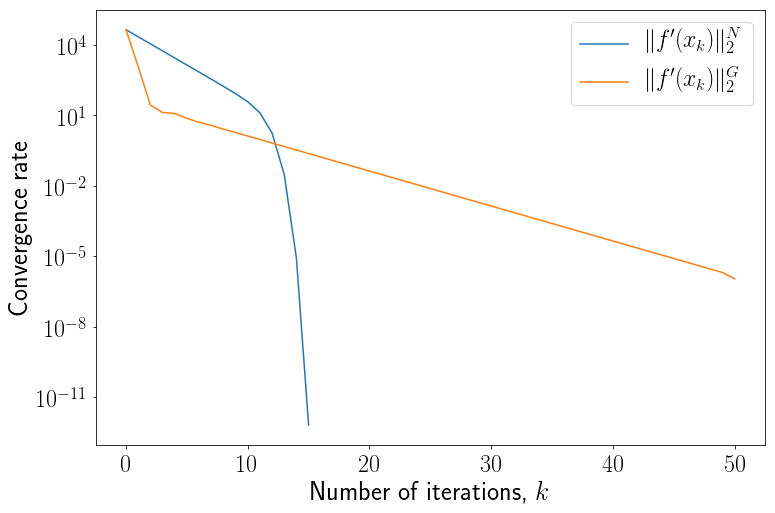

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="$\| f'(x_k) \|^{N}_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="$\| f'(x_k) \|^{G}_2$")
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Convergence rate", fontsize=26)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend(loc="best", fontsize=24)

#### Сравнение времени работы

In [23]:
%timeit newton.solve(x0, tol=1e-6, max_iter=100)
%timeit gd.solve(x0, tol=1e-6, max_iter=200)

2.12 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


522 ms ± 53.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Метод Ньютона даёт очень точное решение за длительное время
- Градиентный спуска даёт не очень точное решение, но гораздо быстрее
- Часто бывает, что очень точное решение не требуется, поэтому градиентный спуск может быть предпочтительнее

# Семинар, часть 2
## Квазиньютоновские методы

## Сравнительный анализ метода Ньютона и градиентного спуска

Метод | Скорость сходимости | Сложность | Аффинная инвариантность | Требования к $f(x)$
:---: | :---: | :---: | :---: | :---:
Градиентный спуск | Глобально линейная | $O(n) + $ определение шага | Нет | Дифференцируема; градиент липшицев
Метод Ньютона | Локально квадратичная | $O(n^3) + $ определение шага | Да | Дважды диференцируема; гессиан липшицев, положительно определён

## Как уменьшить сложность хранения и вычисления?

- Сложность вычисления можно уменьшить с помощью
    - Квазиньютоновские методы, они же методы переменной метрики
    - Требуется хранение матрицы $n \times n$
    
- Сложность вычисления и хранения можно уменьшить 
    - квазиньютоновские методы с ограниченной памятью, например [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) (Limited Broyden-Fletcher-Goldfarb-Shanno)
    - НЕ требуется хранить матрицу
    - вместо этого хранятся $k \ll n$ векторов из $\mathbb{R}^n$

## Общая схема квазиньютоновских методов

```python
def QuasiNewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    H = I
    
    while True:
        
        h = -H.dot(grad_f(x))
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
        H = UpdateH(H, f(x), grad_f(x))
            
    return x
```

### Детали реализации

- Не должно быть операций сложностью $O(n^3)$, то есть никаких матричных умножений и решений линейных систем (cf. [реализацию в SciPy](https://github.com/scipy/scipy/blob/v0.18.1/scipy/optimize/optimize.py#L874-L976))
- Только правило Вольфа гарантирует соблюдения условия кривизны $y_k^{\top}s_k > 0$
- Параметры в правиле Вольфа обычно следующие
    - $\alpha_0 = 1$ необходим для сверхлинейной скорости
    - $\beta_1 = 10^{-4}$, $\beta_2 = 0.9$
- Способы инициализации $H_0$
    - единичная матрица
    - $H_0 = \frac{y_0^{\top}s_0}{y_0^{\top}y_0}I$ **после** первого шага, но до вычисления $H_1$.При вычислении $x_1$  используется $H_0 = I$
    - $H_0 = \delta \|g_0\|^{-1}_2 I$, параметр $\delta$ необходимо заранее задать
- При использовании $B$ вместо $H$ нужно хранить $B$ в виде $LDL^{\top}$ разложения и обновлять не саму матрицу $B$, а её разложение. Это явно делается за $O(n^2)$. Вычисление $h_k$ - это решение линейной системы с предвычисленным раздложением матрицы, следовательно сложность также $O(n^2)$. Этот подход позволяет контролировать устройчивость в диагонали матрицы $D$. На практике предпочтительнее работать с матрицей $H$


## Эксперименты

### Поиск аналитического центра системы неравенств

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

In [8]:
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as scopt
plt.rc("text", usetex=True)

In [9]:
n = 3000
m = 100
x0 = np.zeros(n)
max_iter = 100
tol = 1e-5
A = np.random.rand(m, n) * 10

In [10]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) + 2 * x / (1 - np.power(x, 2))

In [11]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [13]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
    "BFGS": methods.fo.BFGS(f, grad_f),
    "DFP": methods.fo.DFP(f, grad_f),
    "LBFGS": methods.fo.LBFGS(f, grad_f),
}

In [14]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")
scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=grad_f, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6584213191877
Norm of gradient = 5.235826255422153e-06
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 24 iterations
Function value = -706.6584213191762
Norm of gradient = 7.959563814387208e-06
	 Method DFP
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -706.6580511883524
Norm of gradient = 0.052359320627027355
	 Method LBFGS
Required tolerance achieved!
Convergence in 8 iterations
Function value = -706.658421319185
Norm of gradient = 5.590713874268251e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 16 iterations
Function value = -706.6584213187451


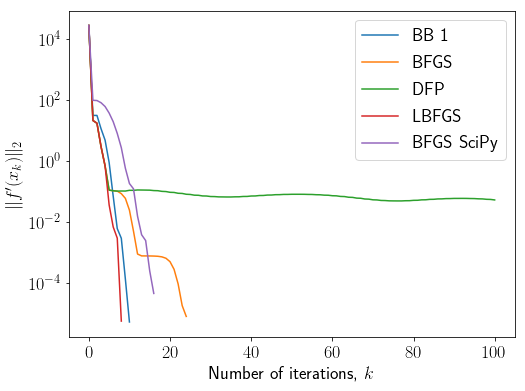

In [15]:
plt.figure(figsize=(8, 6))

for m in method:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label="BFGS SciPy")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [16]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=grad_f, tol=tol, options={"maxiter": max_iter})

	 Method BB 1
7.15 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


5.39 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Method DFP


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


10.1 s ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Method LBFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


38.8 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.1 s ± 633 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Плохо обусловленная задача 

In [17]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 50.00000000000022


In [18]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [19]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=1),
    "BB 2": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=2),
    "BFGS": methods.fo.BFGS(f, gradf),
    "DFP": methods.fo.DFP(f, gradf),
    "GD": methods.fo.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A, b)),
    "LBFGS": methods.fo.LBFGS(f, gradf, hist_size=10),
}

In [20]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")

scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=gradf, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 73 iterations
Function value = -2.628635907019471
Norm of gradient = 9.671207899107351e-06
	 Method BB 2
Required tolerance achieved!
Convergence in 59 iterations
Function value = -2.6286359070462626
Norm of gradient = 6.400767895111321e-06
	 Method BFGS
Required tolerance achieved!
Convergence in 47 iterations
Function value = -2.628635907063715
Norm of gradient = 7.885614938182122e-06
	 Method DFP
Required tolerance achieved!
Convergence in 98 iterations
Function value = -2.6286359070628835
Norm of gradient = 7.86221581946483e-06
	 Method GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -2.6285605935675673
Norm of gradient = 0.017674457931711754
	 Method LBFGS
Required tolerance achieved!
Convergence in 42 iterations
Function value = -2.6286359070581016
Norm of gradient = 9.745120024173308e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 60 iterations
Function val

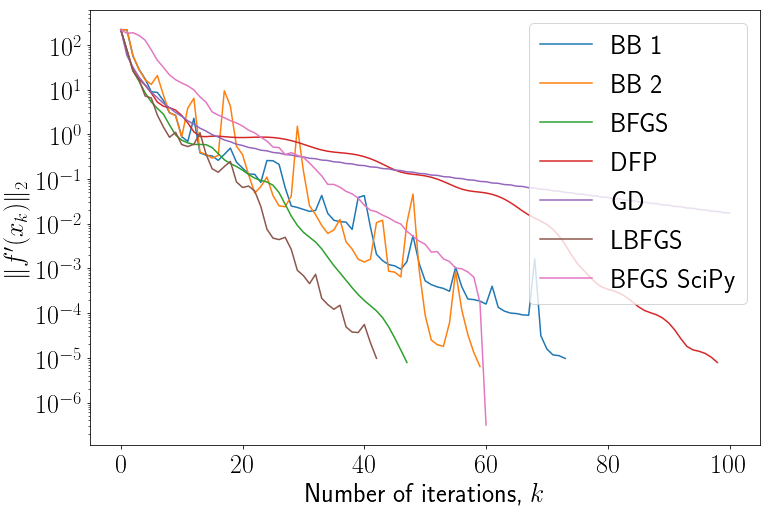

In [21]:
plt.figure(figsize=(12, 8))
fontsize = 26
for m in method:   
    plt.semilogy([np.linalg.norm(gradf(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)